# Post process for ensembling average
    - layer:8, neuron:72
## Define task to postprocess
##  task  = ['predict', 'cross_validation']
    - cross_validation is for post process
### 'cross_validation': for cross validation; has 7 folds
### 'predict': for test using parameters chose by cross validation; has 1 fold --> fold8
##  force = ['CL', 'CD']
##  filt  = ['bessel', 'no filter']
    - no filter for all CL, CD

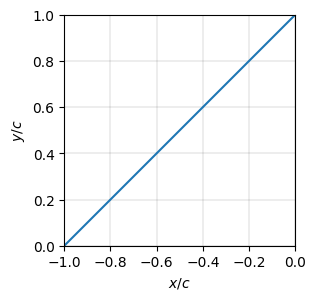

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-1, 1, 100)
y = x+1
fig,ax = plt.subplots(figsize=(5,3))
ax.plot(x, y)
ax.set_xlim(-1, 0)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.set_xlabel('$x/c$')
ax.set_ylabel('$y/c$')
ax.grid(color='k', linestyle='-', linewidth=0.1)
fig.savefig('deltawing_2d.svg')

In [2]:
task = 'predict' 
force = 'CL'     
filt = 'no filter' # only for cp; no cl or cd filter

if task == 'cross_validation':
    folds = 7
    print('Post process for ', force)
elif task == 'predict':
    folds = 1
else:
    print('Error. Please define your task.') 
print('Define the task complete.')

Define the task complete.


In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import bessel
from scipy.signal import filtfilt

#Load the variable from ensemble average prediction; only (layer,neuron): (3,32), (5,64), (8,72) for ensembling
num_neuron = [72] #[32,64,72]      [16, 24, 32, 40, 48, 56, 64, 72]
num_layer  = [8]  #[3,5,8]         [1,  2,  3  ,4,  5,  6,  7,  8]
epoch_total = 200
weight_decay = 0 # 5e-4 # l2 regularization hyperparameter
learn_rate   = 1e-5 # 1e-4
batch_how    = 200  # 200

ensemble_num = 30

In [4]:
# read data
# folder path
data_path = 'D:/myProject/Exam/Thesis/dashuai/deltaWing/organized_data_from_Frieder/data_force_on_earth_Coordinate_System/' + '2023-01-11-filter-no/gust_dataframe.xlsx'

# read the excel data
gust_origin = pd.read_excel(data_path)

In [5]:
# check data
gust_origin.head()

,case_number,Cp1_t,Cp2_t,Cp3_t,Cp4_t,Cp5_t,Cp6_t,Cp7_t,Cp8_t,Cp9_t,Cp10_t,Cp12_t,Cp13_t,Cp14_t,Cp15_t,Cp16_t,Cp0_t,CL,CD
0,case_01,-1.020413,-0.610013,-0.776402,-0.992375,-0.427389,-0.471947,-0.578770,-0.767883,-1.005905,-0.242947,-0.281585,-0.324500,-0.398877,-0.580220,-1.233073,0.889897,0.533331,0.125085
1,case_01,-1.018687,-0.608741,-0.777038,-0.988559,-0.426753,-0.471221,-0.572956,-0.767793,-1.005815,-0.244037,-0.290489,-0.330588,-0.403783,-0.581219,-1.233618,0.891896,0.520047,0.117766
2,case_01,-1.027681,-0.610286,-0.781126,-0.999098,-0.418213,-0.483122,-0.565142,-0.742717,-1.013083,-0.240766,-0.283311,-0.323319,-0.398604,-0.582037,-1.229530,0.899073,0.527826,0.136049
3,case_01,-1.029044,-0.612739,-0.789030,-0.994555,-0.420121,-0.474855,-0.562689,-0.717641,-1.015808,-0.243038,-0.282130,-0.324046,-0.394698,-0.586307,-1.229802,0.900709,0.546522,0.142592
4,case_01,-1.020867,-0.613284,-0.797571,-0.992466,-0.411490,-0.469676,-0.574954,-0.699834,-1.012538,-0.244128,-0.285128,-0.329406,-0.388156,-0.589487,-1.221171,0.904797,0.518274,0.123129


In [6]:
# set the first column as index, i.e. set case_nn as index, for convenience
gust_origin.set_index('case_number', inplace=True)
print(gust_origin.shape)
# check the first 5 columns
gust_origin.head()

(80000, 18)


,Cp1_t,Cp2_t,Cp3_t,Cp4_t,Cp5_t,Cp6_t,Cp7_t,Cp8_t,Cp9_t,Cp10_t,Cp12_t,Cp13_t,Cp14_t,Cp15_t,Cp16_t,Cp0_t,CL,CD
case_number,,,,,,,,,,,,,,,,,,
case_01,-1.020413,-0.610013,-0.776402,-0.992375,-0.427389,-0.471947,-0.578770,-0.767883,-1.005905,-0.242947,-0.281585,-0.324500,-0.398877,-0.580220,-1.233073,0.889897,0.533331,0.125085
case_01,-1.018687,-0.608741,-0.777038,-0.988559,-0.426753,-0.471221,-0.572956,-0.767793,-1.005815,-0.244037,-0.290489,-0.330588,-0.403783,-0.581219,-1.233618,0.891896,0.520047,0.117766
case_01,-1.027681,-0.610286,-0.781126,-0.999098,-0.418213,-0.483122,-0.565142,-0.742717,-1.013083,-0.240766,-0.283311,-0.323319,-0.398604,-0.582037,-1.229530,0.899073,0.527826,0.136049
case_01,-1.029044,-0.612739,-0.789030,-0.994555,-0.420121,-0.474855,-0.562689,-0.717641,-1.015808,-0.243038,-0.282130,-0.324046,-0.394698,-0.586307,-1.229802,0.900709,0.546522,0.142592
case_01,-1.020867,-0.613284,-0.797571,-0.992466,-0.411490,-0.469676,-0.574954,-0.699834,-1.012538,-0.244128,-0.285128,-0.329406,-0.388156,-0.589487,-1.221171,0.904797,0.518274,0.123129


In [7]:
# bessel filter for every column; only filt CP
if filt == 'bessel':
    
    gust_index   = gust_origin.index
    gust_column  = gust_origin.columns
    gust_no_filter = np.zeros((gust_index.nunique(),len(gust_origin.loc[['case_01']]),len(gust_origin.columns))) # (32,2500,18)
    gust_filter    = np.zeros((gust_index.nunique(),len(gust_origin.loc[['case_01']]),len(gust_origin.columns)))
    case_all_no = (np.linspace(0,31,32)).astype(int)
    b, a = bessel(8, 0.01) # define the bessel filter; 8 is the filter order; 0.01 is the W_n (between 0 to 1)
    
    for i in case_all_no:      # i is the case number
        case_numer = 'case_' + str(i+1).zfill(2)
        gust_no_filter[i] = gust_origin.loc[[case_numer]].to_numpy()
        for j in range(len(gust_origin.columns)-2):       # j is the CP and CL CD number
            gust_filter[i][:,j] = filtfilt(b, a, gust_no_filter[i][:,j]) # bessel filter for cp
        gust_filter[i][:,len(gust_origin.columns)-2] = gust_no_filter[i][:,len(gust_origin.columns)-2]  # no filter for CL
        gust_filter[i][:,len(gust_origin.columns)-1] = gust_no_filter[i][:,len(gust_origin.columns)-1]  # no filter for CD
    gust = pd.DataFrame(data=np.concatenate(gust_filter,axis=0), index=gust_index, columns=gust_column)
    
elif filt == 'no filter':
    gust = gust_origin
    
else:
    print('Error. Please define your filter.')

In [8]:
# check gust
gust.head()

,Cp1_t,Cp2_t,Cp3_t,Cp4_t,Cp5_t,Cp6_t,Cp7_t,Cp8_t,Cp9_t,Cp10_t,Cp12_t,Cp13_t,Cp14_t,Cp15_t,Cp16_t,Cp0_t,CL,CD
case_number,,,,,,,,,,,,,,,,,,
case_01,-1.020413,-0.610013,-0.776402,-0.992375,-0.427389,-0.471947,-0.578770,-0.767883,-1.005905,-0.242947,-0.281585,-0.324500,-0.398877,-0.580220,-1.233073,0.889897,0.533331,0.125085
case_01,-1.018687,-0.608741,-0.777038,-0.988559,-0.426753,-0.471221,-0.572956,-0.767793,-1.005815,-0.244037,-0.290489,-0.330588,-0.403783,-0.581219,-1.233618,0.891896,0.520047,0.117766
case_01,-1.027681,-0.610286,-0.781126,-0.999098,-0.418213,-0.483122,-0.565142,-0.742717,-1.013083,-0.240766,-0.283311,-0.323319,-0.398604,-0.582037,-1.229530,0.899073,0.527826,0.136049
case_01,-1.029044,-0.612739,-0.789030,-0.994555,-0.420121,-0.474855,-0.562689,-0.717641,-1.015808,-0.243038,-0.282130,-0.324046,-0.394698,-0.586307,-1.229802,0.900709,0.546522,0.142592
case_01,-1.020867,-0.613284,-0.797571,-0.992466,-0.411490,-0.469676,-0.574954,-0.699834,-1.012538,-0.244128,-0.285128,-0.329406,-0.388156,-0.589487,-1.221171,0.904797,0.518274,0.123129


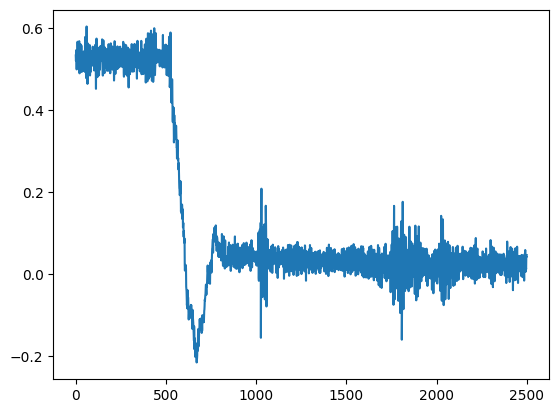

In [9]:
# check force
plt.plot(gust[[force]].to_numpy()[0:2500,0])

In [10]:
# retrieve CP, 16(CP) + 16(CP_1st_order) + 16(CP_2nd_order) = 48 columns in total
# simply drop CL and CD, then the rest is CP
CP = gust.drop(['CL','CD'],axis=1, inplace=False)
CP.head()

,Cp1_t,Cp2_t,Cp3_t,Cp4_t,Cp5_t,Cp6_t,Cp7_t,Cp8_t,Cp9_t,Cp10_t,Cp12_t,Cp13_t,Cp14_t,Cp15_t,Cp16_t,Cp0_t
case_number,,,,,,,,,,,,,,,,
case_01,-1.020413,-0.610013,-0.776402,-0.992375,-0.427389,-0.471947,-0.578770,-0.767883,-1.005905,-0.242947,-0.281585,-0.324500,-0.398877,-0.580220,-1.233073,0.889897
case_01,-1.018687,-0.608741,-0.777038,-0.988559,-0.426753,-0.471221,-0.572956,-0.767793,-1.005815,-0.244037,-0.290489,-0.330588,-0.403783,-0.581219,-1.233618,0.891896
case_01,-1.027681,-0.610286,-0.781126,-0.999098,-0.418213,-0.483122,-0.565142,-0.742717,-1.013083,-0.240766,-0.283311,-0.323319,-0.398604,-0.582037,-1.229530,0.899073
case_01,-1.029044,-0.612739,-0.789030,-0.994555,-0.420121,-0.474855,-0.562689,-0.717641,-1.015808,-0.243038,-0.282130,-0.324046,-0.394698,-0.586307,-1.229802,0.900709
case_01,-1.020867,-0.613284,-0.797571,-0.992466,-0.411490,-0.469676,-0.574954,-0.699834,-1.012538,-0.244128,-0.285128,-0.329406,-0.388156,-0.589487,-1.221171,0.904797


In [11]:
# retrieve CL or CD
if force == 'CL':
    CL = gust[['CL']]
elif force == 'CD':
    CD = gust[['CD']]
else:
    print('Error. Please define your force to post process.')
gust[['CL']].head()

,CL
case_number,
case_01,0.533331
case_01,0.520047
case_01,0.527826
case_01,0.546522
case_01,0.518274


In [12]:
# retrieve for 8 different folds
# read the split .txt file; the number means the cases for test
split_path = 'D:/myProject/Exam/Thesis/dashuai/deltaWing/organized_data_from_Frieder/data_force_on_earth_Coordinate_System/' + 'delta_wing_32cases_split_random.txt'
with open(split_path, 'r') as file1:    
    fold_split = file1.read().splitlines()       # split by \n
fold_split = fold_split[1:] # drop the head line
for i in range(8):
    fold_split[i] = fold_split[i][9:].split()    # split by space; the number starts from 10th character.
    for j in range(4):
        fold_split[i][j] = int(fold_split[i][j]) # convert string to int
fold_split

[[4, 19, 26, 30],
 [5, 14, 31, 32],
 [1, 18, 22, 29],
 [6, 10, 16, 17],
 [2, 8, 11, 24],
 [3, 7, 15, 27],
 [9, 12, 21, 23],
 [13, 20, 25, 28]]

In [13]:
# define the 32 case number
case_all_num = np.arange(gust.index.nunique()) + 1
print(case_all_num)
print(case_all_num.shape)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
(32,)


In [14]:
# find the case number for train and test cases;
if task == 'cross_validation':
    train_case = [ [0]*24 for _ in range(folds) ] # initialize 2d list; list for 'case_nn'
    test_case  = [ [0]*4 for _ in range(folds) ]
    # find case number for cross validation folds: fold1~fold7
    for i in range(folds): 
        train_case_temp = np.setdiff1d( case_all_num, np.concatenate((fold_split[i], fold_split[-1]))) 
        # drop test case and the last one (which is for fold 8 , final test)
        test_case_temp  = fold_split[i]

        # conbine to 'case_nn' sample for train and test case; prepare for next step
        for j in range(len(train_case_temp)):
            train_case[i][j] = 'case_' + str(train_case_temp[j]).zfill(2)
        for k in range(len(test_case_temp)):
            test_case[i][k]  = 'case_' + str(test_case_temp[k]).zfill(2)
            
elif task == 'predict': 
    train_case = [ [0]*28 for _ in range(folds) ] # initialize 2d list; list for 'case_nn'
    test_case  = [ [0]*4 for _ in range(folds) ]
    # find case number for test fold: fold8  
    train_case_temp = np.setdiff1d(case_all_num, fold_split[-1])
    test_case_temp  = fold_split[-1]
    for jj in range(len(train_case_temp)):
        train_case[-1][jj] = 'case_' + str(train_case_temp[jj]).zfill(2)
    for kk in range(len(test_case_temp)):
        test_case[-1][kk]  = 'case_' + str(test_case_temp[kk]).zfill(2)

else:
    print('Error. Please define your task.')

print(test_case[0])
print('Done!')

['case_13', 'case_20', 'case_25', 'case_28']
Done!


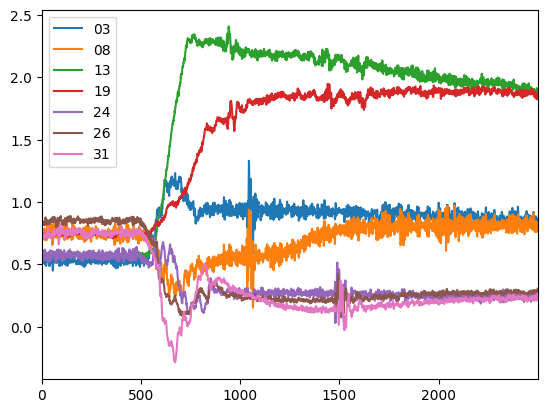

In [48]:
# check force plot
fig, ax = plt.subplots()
for i in [3,8,13,19,24,26,31]:
    plt.plot(CL.loc['case_'+ str(i).zfill(2)].to_numpy(),label=str(i).zfill(2))
ax.legend()
ax.margins(x=0)

In [15]:
#  prepare for train and test data sets
if task == 'cross_validation':
    F_train_rec = np.zeros([folds,60000,1]) # 24*2500 = 60000
    F_test_rec  = np.zeros([folds,10000,1])  # 4*2500  = 10000
    P_train_rec = np.zeros([folds,60000,48])
    P_test_rec  = np.zeros([folds,10000,48])

    for i in range(folds): # 7 folds for training, the last one is for test, not retrieve here, since this is for training
        if force == 'CL':
            F_train_rec[i] = CL.loc[train_case[i]].to_numpy()
            F_test_rec[i]  = CL.loc[test_case[i]].to_numpy()
        elif force == 'CD':
            F_train_rec[i] = CD.loc[train_case[i]].to_numpy()
            F_test_rec[i]  = CD.loc[test_case[i]].to_numpy()
        else:
            print('Error. Please define force.')

        P_train_rec[i] = CP.loc[train_case[i]].to_numpy()
        P_test_rec[i]  = CP.loc[test_case[i]].to_numpy()

elif task == 'predict':
    F_train_rec = np.zeros([folds,70000,1]) # 28*2500 = 70000
    F_test_rec  = np.zeros([folds,10000,1])  # 4*2500  = 10000
    P_train_rec = np.zeros([folds,70000,16])
    P_test_rec  = np.zeros([folds,10000,16])
    
    if force == 'CL':
        F_train_rec[0] = CL.loc[train_case[0]].to_numpy()
        F_test_rec[0]  = CL.loc[test_case[0]].to_numpy()
    elif force == 'CD':
        F_train_rec[0] = CD.loc[train_case[0]].to_numpy()
        F_test_rec[0]  = CD.loc[test_case[0]].to_numpy()
    else:
        print('Error. Please define force.')

    P_train_rec[0] = CP.loc[train_case[0]].to_numpy()
    P_test_rec[0]  = CP.loc[test_case[0]].to_numpy()
    
else:
    print('Error. Please define your task.')
    
print('Done')

Done


In [16]:
print(task)
print(force)
print(folds)

predict
CL
1


In [17]:
# load the ensembling average results
result_folder = 'D:/myProject/Exam/Thesis/dashuai/deltaWing/code/2023-01-16-pred-cl-ensemble-average-cp-nofilter/ensemble-data/'
predictions = {}
for i in num_neuron: # define the neurons
    for j in num_layer: # define the hidden layers 
        for k in range(ensemble_num): # start loop for 7 folds cross-validation
            # print('loading ensemble_num: %d' % (i))
            predictions[k,i,j] = np.array(pickle.load(
                open(result_folder+'F_pred_ensemble_num_'+str(k)+'_neuron_'+str(i)+'_layer_'+str(j)+'.dat', 'rb')))
            # respahe predictions (200,10000,1) --> (200,10000)
            predictions[k,i,j] = predictions[k,i,j].reshape(epoch_total,len(P_test_rec[0])).T

print(predictions[0,72,8].shape)
print('Done!')
            

(10000, 200)
Done!


In [18]:
# this function finds the ensemble average of the epoch predictions and the std  history
# it returns the average result (array) and the std (array)
def ensemble_average(epoch_pred):
    sum_temp = np.zeros((len(epoch_pred[:,0]),len(epoch_pred[0,:])))
    sum_temp[:,0] = epoch_pred[:,0]
    std_hist = np.zeros((len(epoch_pred[0,:])))
    std_hist[0] = np.std(sum_temp[:,0])
    ensemble_averg = np.zeros((len(epoch_pred[:,0]),len(epoch_pred[0,:])))
    ensemble_averg[:,0] = epoch_pred[:,0]
    for i in range(len(epoch_pred[0,:])-1):
        sum_temp[:,i+1] = sum_temp[:,i] + epoch_pred[:,i+1]
        std_hist[i+1] = np.std(sum_temp[:,i+1]/(i+2))
        ensemble_averg[:,i+1] = sum_temp[:,i+1]/(i+2)
    return(std_hist, ensemble_averg)

In [19]:
# test function ensemble_average
a = np.array([[1,1,2,2],[1,2,1,3],[1,1,1,5]])
(b,c) = ensemble_average(a)
print(c)
print(b == np.std(np.array([[1,2/2,4/3,6/4],[1,3/2,4/3,7/4],[1,2/2,3/3,8/4]]),axis=0))

[[1.         1.         1.33333333 1.5       ]
 [1.         1.5        1.33333333 1.75      ]
 [1.         1.         1.         2.        ]]
[ True  True  True  True]


Text(0, 0.5, 'MSE')

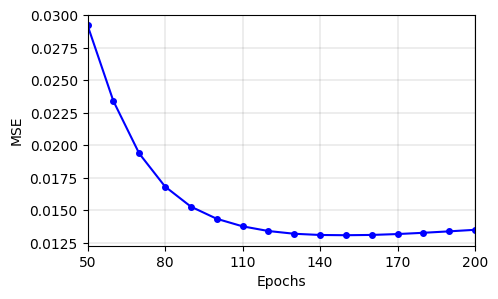

In [20]:
# this cell calcalutes the mse of different ensembling average: 50,60,70,80,90,...200
from sklearn.metrics import mean_squared_error as mse

ensemble_use = np.arange(50,210,10)
mse_ensemble_use  = {} # dictionary, with keys and values
epoch_hist_use    = np.zeros([len(ensemble_use),len(F_test_rec[0]),ensemble_num]) # 16*10000*30: 16 to show the mse, 10000 samples, 30 repeats
ensemble_avrg_use = {}
ensemble_std_use  = {}
ensemble_avrg_use = {}

neuron_this = num_neuron[0]
layer_this  = num_layer[0]

fig,ax_use = plt.subplots(figsize=(5,3))
for j in ensemble_use: # [50,60,70,80,90,...200]
    for i in range(ensemble_num): # repeat ensemble_num times with same hyperparameters
        epoch_hist_use[int(j/10-5),:,i] = predictions[i,neuron_this,layer_this][:,j-1]
        
    (ensemble_std_use[j], ensemble_avrg_use[j]) = ensemble_average(epoch_hist_use[int(j/10-5)])
    
    mse_ensemble_use[j] = mse(ensemble_avrg_use[j][:,-1], F_test_rec[0][:,:])

ax_use.plot(mse_ensemble_use.keys(),mse_ensemble_use.values(),color='blue', linewidth=1.5,marker='.',markersize=8)
ax_use.set_xlim(50,200)
ax_use.set_xticks(np.arange(50,210,30).tolist())
# ax_use.set_ylim(0.012,0.030)
ax_use.grid(color='k', linestyle='-', linewidth=0.1)
ax_use.set_xlabel('Epochs')
ax_use.set_ylabel('MSE')
# fig.savefig('ensemble_error_noFilter_neuron%d_layer%d.png' % (neuron_this,layer_this), bbox_inches='tight', dpi=300)
# fig.savefig('ensemble_error_noFilter_neuron%d_layer%d.svg' % (neuron_this,layer_this), bbox_inches='tight')

(0.0, 30.0)

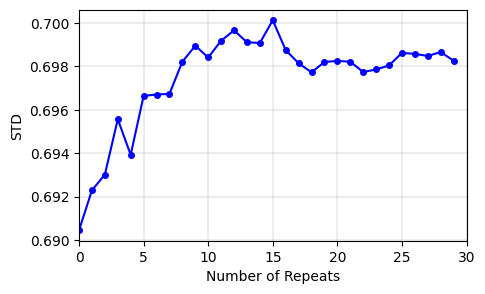

In [21]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(ensemble_std_use[200],color='blue', linewidth=1.5,marker='.',markersize=8)
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.set_xlabel('Number of Repeats')
ax.set_ylabel('STD')
ax.margins(x=0)
ax.set_xlim(0,30)
# fig.savefig('STD_repeat_noFilter_neuron%d_layer%d.png' % (neuron_this,layer_this), bbox_inches='tight', dpi=300)
# fig.savefig('STD_repeat_noFilter_neuron%d_layer%d.svg' % (neuron_this,layer_this), bbox_inches='tight')

Text(0, 0.5, '$C_{L}$')

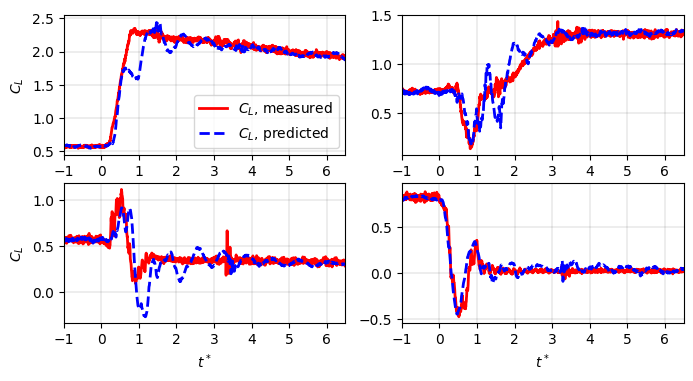

In [22]:
import matplotlib.patches as patches
fig, ax_split = plt.subplots(2,2,figsize=(8,4))
repeat_num = 200 # repeated number: 50 100

T = 0.3 # period is 0.3s
f = 1000 # frequency is 1000Hz
t_star = (np.arange(0,10000) - 500) / f / T 

fig_num = 0 # for count opnly
for i in range(4):
    if fig_num in [0,1]:
        p = 0
        q = fig_num
    else:
        p = 1
        q = fig_num - 2
    ax_split[p,q].plot(t_star[0:2500-1], F_test_rec[0][2500*i:2500*(i+1)-1,:],label='F_test',color='red', linewidth=2)
    ax_split[p,q].plot(t_star[0:2500-1], ensemble_avrg_use[repeat_num][2500*i:2500*(i+1)-1,-1],label='pred_average', 
                       color='blue', linewidth=2, linestyle='--') # 50 and 200 epochs
    ax_split[p,q].grid(color='k', linestyle='-', linewidth=0.1)
    ax_split[p,q].set_xticks(np.arange(-1,8))
    ax_split[p,q].set_xlim(-1,6.5)
    ax_split[p,q].margins(x=0)
    ax_split[p,q].set_xlabel('$t^*$')
    fig_num = fig_num + 1
ax_split[0,0].set_ylabel('$C_{L}$')
ax_split[0,0].legend(['$C_{L}$, measured','$C_{L}$, predicted'])
ax_split[1,0].set_ylabel('$C_{L}$')

# fig.savefig('ensemble%d_pred_noFilter_neuron%d_layer%d.png' % (repeat_num,neuron_this,layer_this), bbox_inches='tight', dpi=300)
# fig.savefig('ensemble%d_pred_noFilter_neuron%d_layer%d.svg' % (repeat_num,neuron_this,layer_this), bbox_inches='tight')

In [24]:
# save results to combine the data with bessel filter
import pickle

# #Save the variable
# pickle.dump(predictions, open("predictions.dat", "wb"))
# #Load the variable
# variable = pickle.load(open("predictions.dat", "rb"))

pickle.dump(mse_ensemble_use, open("../2023-01-16-mse-std-pred/mse_ensemble_use_no_filter.dat", "wb"))
pickle.dump(ensemble_std_use, open("../2023-01-16-mse-std-pred/ensemble_std_use_no_filter.dat", "wb"))
pickle.dump(F_test_rec, open("../2023-01-16-mse-std-pred/F_test_rec.dat", "wb"))
pickle.dump(ensemble_avrg_use, open("../2023-01-16-mse-std-pred/ensemble_avrg_use_no_filter.dat", "wb"))

Text(0.5, 1.0, 'delta wing')

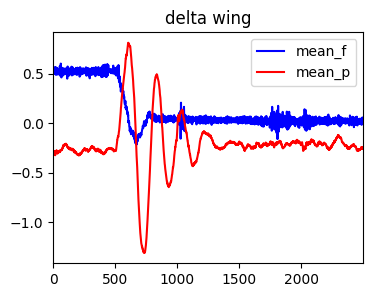

In [73]:
fig,ax = plt.subplots(figsize=(4,3))
ax.plot(CL.loc['case_01'].to_numpy(),color='b', label='mean_f')
ax.plot(CP.loc['case_01'].to_numpy()[:,10],color='r', label='mean_p')
ax.legend()
ax.margins(x=0)
ax.set_title('delta wing')